In [1]:
import pandas as pd
import numpy as np

In [2]:
#Load datasets
df = pd.read_csv('billboard_lyrics_1964-2015.csv', encoding = 'ISO-8859-1')

def clean_data(df):
    df = df.replace({'\n': ' '}, regex=True)
    df.dropna()
    
    df['word_count'] = df['Lyrics'].str.split().str.len()
    df = df[df['word_count'] != 1]
    df = df[df['word_count'] >= 100]
    df = df[df['word_count'] <= 1000] 
    df = df[df['Year'] >= 2000]
    return df

#Now this is good data...
df=clean_data(df)
df.head(5)

,Rank,Song,Artist,Year,Lyrics,Source,word_count
3500,1,breathe,faith hill,2000,i can feel the magic floating in the air bein...,1.0,246.0
3501,2,smooth,santana featuring rob thomas,2000,man its a hot one like seven inches from the ...,1.0,341.0
3502,3,maria maria,santana featuring the product gb,2000,ladies and gents turn up your sound systems t...,1.0,374.0
3503,4,i wanna know,joe,2000,yeah oh yeah alright oh oh ohits amazing how ...,1.0,463.0
3504,5,everything you want,vertical horizon,2000,somewhere theres speaking its already coming ...,1.0,328.0


We now get the lyrics as a seperate dataframe and preprocess the text.

In [4]:
import spacy

# Import only relevant modules 
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])

# Tokenization, stop word removal, and lemmatization.
def preprocess(text):
    doc = nlp(text)
    output = []
    for token in doc:
        if not token.is_stop and token.text:
            if token.text.isalpha() and len(token) > 2:
                output.append(token.text)
    return output

def preprocess_lyrics(df):
    documents=[]
    for row in df.itertuples():
        lyric=row[5]
        documents.append(preprocess(str(row)))
    return documents
        
hit_documents=preprocess_lyrics(df)

print(hit_documents[:3])

[['hill', 'feel', 'magic', 'floating', 'air', 'gets', 'way', 'watch', 'sunlight', 'dance', 'face', 'swept', 'awayall', 'thoughts', 'settle', 'breeze', 'lying', 'wrapped', 'arms', 'world', 'fades', 'away', 'thing', 'hear', 'beating', 'heartcause', 'feel', 'breathe', 'washing', 'suddenly', 'melting', 'left', 'prove', 'baby', 'need', 'caught', 'touch', 'slow', 'steady', 'rush', 'baby', 'way', 'loves', 'suppose', 'feel', 'breathe', 'breathein', 'way', 'know', 'heart', 'waking', 'walls', 'come', 'tumbling', 'closer', 'felt', 'know', 'know', 'need', 'words', 'right', 'nowi', 'feel', 'breathe', 'washing', 'suddenly', 'melting', 'left', 'prove', 'baby', 'need', 'caught', 'touch', 'slow', 'steady', 'rush', 'baby', 'way', 'loves', 'suppose', 'feel', 'breathe', 'breathecaught', 'touch', 'slow', 'steady', 'rush', 'baby', 'way', 'loves', 'suppose', 'feel', 'breathe', 'breathei', 'feel', 'magic', 'floating', 'air', 'gets', 'way'], ['featuring', 'rob', 'thomas', 'man', 'hot', 'like', 'seven', 'inches

We now visualize the dataset after cleaning:

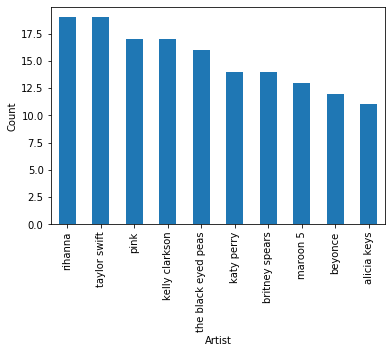

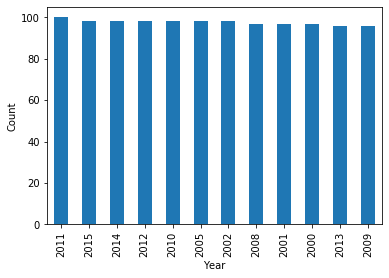

,Rank,Song,Artist,Year,Lyrics,Source,word_count
4969,70,me and my broken heart,rixton,2014,all i need is a little love in my life all i ...,1.0,378.0
4981,82,la la la,naughty boy featuring sam smith,2014,na na la la la la la na na na na na la la na ...,1.0,558.0
3573,74,thats the way,jo dee messina,2000,everybody wants an easy ride on the merrygoro...,1.0,366.0
3930,31,overnight celebrity,twista,2004,oh you didnt think we can it again twista kan...,1.0,858.0
3777,78,here is gone,goo goo dolls,2002,you and i got somethin but its all and then i...,1.0,298.0
4947,48,the man,aloe blacc,2014,girl you can tell everybody yeah you can tell...,1.0,511.0
5013,14,take me to church,hozier,2015,my lovers got humour shes the giggle at a fun...,1.0,462.0
4530,31,say aah,trey songz featuring fabolous,2010,aye when i give you these keys homeboy dont m...,1.0,657.0
4223,24,how to save a life,the fray,2007,step one you say we need to talk he walks you ...,3.0,381.0
3537,38,come on over baby all i want is you,christina aguilera,2000,come on over come on over baby come on over co...,3.0,482.0


In [6]:
import matplotlib.pyplot as plt

artist_count = df['Artist'].value_counts().head(10)
year_count = df['Year'].value_counts().head(12)

artist_count.plot.bar()
plt.xlabel('Artist')
plt.ylabel('Count')
plt.show()

year_count.plot.bar()
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

df.sample(n=10)

Then, write code to train an [LdaModel] for $k=10$ topics, and using default values for all other parameters.
This is the topic model that each of the songs will need to be compared against.

In [7]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Set training parameters.
k = 10

# Create a dictionary representation of the documents.
dictionary = Dictionary(hit_documents)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation of the documents.
hit_corpus = [dictionary.doc2bow(doc) for doc in hit_documents]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(hit_corpus))

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary. dont work w/o it temp is black magic
id2word = dictionary.id2token

hit_model = LdaModel(
    corpus=hit_corpus,
    id2word=id2word,
    num_topics=10
    )

hit_model.print_topics()

Number of unique tokens: 1035
Number of documents: 1553


[(0,
  '0.031*"gon" + 0.027*"baby" + 0.025*"girl" + 0.024*"let" + 0.012*"yeah" + 0.011*"want" + 0.011*"life" + 0.011*"boy" + 0.010*"boom" + 0.010*"wanna"'),
 (1,
  '0.028*"wanna" + 0.021*"baby" + 0.018*"come" + 0.017*"right" + 0.017*"life" + 0.014*"turn" + 0.013*"time" + 0.012*"night" + 0.011*"lets" + 0.010*"yeah"'),
 (2,
  '0.025*"wanna" + 0.020*"want" + 0.017*"girl" + 0.015*"feel" + 0.015*"yeah" + 0.013*"walk" + 0.013*"baby" + 0.011*"gon" + 0.010*"rock" + 0.010*"way"'),
 (3,
  '0.017*"let" + 0.017*"time" + 0.016*"right" + 0.015*"baby" + 0.014*"gon" + 0.013*"want" + 0.012*"shake" + 0.012*"girl" + 0.012*"wanna" + 0.010*"thing"'),
 (4,
  '0.025*"ill" + 0.021*"way" + 0.017*"yeah" + 0.017*"wanna" + 0.013*"baby" + 0.013*"hey" + 0.013*"wit" + 0.012*"girl" + 0.011*"right" + 0.011*"feel"'),
 (5,
  '0.038*"want" + 0.024*"gon" + 0.020*"baby" + 0.017*"come" + 0.015*"girl" + 0.012*"time" + 0.012*"need" + 0.011*"way" + 0.011*"ill" + 0.011*"tell"'),
 (6,
  '0.050*"baby" + 0.025*"need" + 0.024*"girl

Get song data from the 380,000+ lyrics dataset. Since some data entries are bad we remove them from the dataset. We only use songs from year >=2000.

In [8]:
lyrics_df = pd.read_csv('lyrics.csv', encoding = 'ISO-8859-1')

#Clean data: remove newlines, NAN-values and lyrics with to low/high word count,
#also remove the "Not Available" genre.
def clean_data(df):
    df = df.replace({'\n': ' '}, regex=True)
    df.dropna()
    
    indexNames = df[df['genre'] == "Not Available"].index
    df.drop(indexNames, inplace=True)
    
    df['word_count'] = df['lyrics'].str.split().str.len()
    df = df[df['word_count'] != 1]
    df = df[df['word_count'] >= 100]
    df = df[df['word_count'] <= 1000]  
    df = df[df['year'] >= 2000]
    return df

#Now this is good data...
lyrics_df = clean_data(lyrics_df)

#Get ten random song from this dataset 
print(lyrics_df['artist'].unique().tolist())

['beyonce-knowles', 'eazy-e', 'asher-monroe', 'alice-on-the-roof', 'borialis', 'demonaz', 'dave-sterling', 'brightwood', 'cenk-r-lr-etin', 'destroy', 'gene-watson', 'a-dream-too-late', 'farben-lehre', 'deichkind', 'fang', 'anna-waronker', 'the-books', 'alathea', 'graveyard', 'chant', 'arcade-fire', 'atsumi-saori', 'funkadelic', 'arthur-big-boy-crudup', 'chuckie', 'brian-simpson', 'asia-nitollano', 'children-18-3', 'evan-taubenfeld', 'exit-this-side', 'brandi-carlile', 'echoterra', 'b3', 'club-america', 'billy-bland', 'chad-brownlee', 'aubrie-sellers', 'beckett', 'the-easton-ellises', 'eljay', 'capleton', 'fatima-mansions', 'gei', 'andy-m-stewart', 'flamboyant-bella', 'claypool-lennon-delirium', 'earthtone9', 'dreadful-shadows', 'the-boy-least-likely-to', 'franco-de-vita', 'c-w-stoneking', 'genghis-tron', 'desert-noises', 'al-stewart', 'the-colors', 'all-caps', 'fatih-erkorng', 'capture-the-crown', 'cheyo-carrillo', 'busy-signal', 'astro-n-out', 'atreyu', 'bless-the-fall', 'del-the-funk

Get ten artists and create a artist-topic model map.

In [66]:
# Get subset of 10 artist datasets
beyonce=lyrics_df[lyrics_df['artist']=='beyonce-knowles']
gorillaz=lyrics_df[lyrics_df['artist']=='gorillaz']
beck=lyrics_df[lyrics_df['artist']=='beck']
arcade_fire=lyrics_df[lyrics_df['artist']=='arcade-fire']
all_american_rejects=lyrics_df[lyrics_df['artist']=='all-american-rejects']
devo=lyrics_df[lyrics_df['artist']=='devo']
adele=lyrics_df[lyrics_df['artist']=='adele']
beach_boys=lyrics_df[lyrics_df['artist']=='beach-boys']
david_bowie=lyrics_df[lyrics_df['artist']=='david-bowie']
bmc=lyrics_df[lyrics_df['artist']=='black-rebel-motorcycle-club']
britney=lyrics_df[lyrics_df['artist']=='britney-spears']
alicia_keys=lyrics_df[lyrics_df['artist']=='alicia-keys']

#Preprocessing for lyrics dataset
structure_words = ["intro", "verse", "bridge", "outro", "hook"]

# Tokenization, stop word removal, and lemmatization.
def preprocess(text):
    doc = nlp(text)
    output = []
    for token in doc:
        if not token.is_stop and token.text:
            if token.lemma_.isalpha() and token.lemma_.lower() not in structure_words and len(token.lemma_)>2:
                output.append(token.lemma_.lower())
    return output

#values.astype('U')
        
#Create artist topic-model map
topic_map={}
documents=[]

#documents=get_lyrics(lyrics_df, 'beyonce-knowles')
for d in devo['lyrics'].tolist():
    documents.append(preprocess(d))
    
print(documents)

[['take', 'worry', 'man', 'sing', 'worry', 'song', 'worry', 'will', 'worry', 'long', 'take', 'worry', 'man', 'sing', 'worry', 'song', 'worry', 'will', 'worry', 'long', 'party', 'laugh', 'have', 'fun', 'take', 'worry', 'man', 'sing', 'worry', 'song', 'fuck', 'come', 'take', 'worry', 'man', 'sing', 'worry', 'song', 'take', 'worry', 'man', 'sing', 'worry', 'song', 'worry', 'will', 'worry', 'long', 'take', 'worry', 'man', 'sing', 'worry', 'song', 'worry', 'will', 'worry', 'long', 'good', 'time', 'right', 'take', 'worry', 'man', 'sing', 'worry', 'song', 'worry', 'will', 'worry', 'long', 'feel', 'comrade', 'take', 'worry', 'man', 'sing', 'worry', 'song', 'worry', 'will', 'worry', 'long', 'take', 'worry', 'man', 'sing', 'worry', 'song', 'worry', 'will', 'worry', 'long', 'take', 'worry', 'man', 'sing', 'worry', 'song', 'worry', 'will', 'worry', 'long', 'good', 'time', 'right'], ['mind', 'come', 'hold', 'hands', 'watch', 'sunrise', 'sea', 'experienced', 'experienced', 'know', 'know', 'probably'

In [67]:
#Beyonce topic model
dictionary = Dictionary(documents)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation of the documents.
artist_corpus = [dictionary.doc2bow(doc) for doc in documents]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(artist_corpus))

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary. dont work w/o it temp is black magic
id2word = dictionary.id2token

artist_model = LdaModel(
    corpus=artist_corpus,
    id2word=id2word,
    num_topics=10
    )

artist_model.print_topics()
                 
#print(documents)

Number of unique tokens: 37
Number of documents: 141


[(0,
  '0.135*"world" + 0.093*"let" + 0.078*"get" + 0.074*"man" + 0.073*"way" + 0.053*"know" + 0.040*"live" + 0.035*"new" + 0.031*"big" + 0.030*"look"'),
 (1,
  '0.132*"man" + 0.118*"girl" + 0.097*"come" + 0.071*"know" + 0.060*"life" + 0.052*"live" + 0.050*"like" + 0.046*"want" + 0.042*"hear" + 0.038*"time"'),
 (2,
  '0.168*"get" + 0.080*"love" + 0.076*"time" + 0.045*"way" + 0.040*"boy" + 0.037*"know" + 0.036*"right" + 0.033*"tell" + 0.032*"think" + 0.032*"thing"'),
 (3,
  '0.103*"come" + 0.097*"let" + 0.085*"try" + 0.066*"want" + 0.049*"big" + 0.046*"hear" + 0.043*"time" + 0.038*"man" + 0.036*"tell" + 0.035*"turn"'),
 (4,
  '0.128*"like" + 0.108*"find" + 0.083*"thing" + 0.047*"get" + 0.045*"live" + 0.043*"man" + 0.042*"take" + 0.039*"try" + 0.037*"world" + 0.034*"time"'),
 (5,
  '0.340*"baby" + 0.075*"think" + 0.053*"like" + 0.041*"want" + 0.040*"tell" + 0.036*"big" + 0.035*"get" + 0.032*"world" + 0.030*"let" + 0.029*"come"'),
 (6,
  '0.402*"long" + 0.143*"because" + 0.013*"get" + 0.0

Compare topic models for all songs lyrics. Euclidian distance is used to calculate "hit-score" for each song.

In [68]:
#Calculate average of all tuples in a list
def average(lst):
    s = 0
    for tup in lst: 
        for i in tup: 
            s += i 
    return s/len(lst) 

#zeropad lists for distance operations
def zeropad(a,b):
    if (len(a) > len(b)):
        diff=len(a) - len(b)
        result = np.zeros(diff) 
        b+=result.tolist()
        return a,b
    else:
        diff=len(a) - len(b)
        result = np.zeros(diff) 
        a+=result.tolist()
        return a,b

#Get the mean of all topic distributions in hit corpus
hit_averages = []
for hit in hit_corpus:
    hit_averages.append(average(hit_model[hit]))   

# Get the mean of all topic distributions in another song corpus
song_averages = []
for song in artist_corpus:
    song_averages.append(average(artist_model[song]))

hit_averages, song_averages = zeropad(hit_averages, song_averages)

# Calculate the distance between the distribution of topics in both corpora
dist = np.linalg.norm(np.asarray(hit_averages) - np.asarray(song_averages))

print(dist)

207.73414439429754
